# JWST Imaging Pipeline

Prepared for AAS Meeting JWebbinar

**Consolidator**: Karl Gordon (kgordon@stsci.edu)| **Latest Update**: 20 Dec 2021

Completed based on the excellent and expansive JWebbinar 3 notebooks written by Bryan Hilbert (hilbert@stsci.edu).

Please see the JWebbinar 3, 4, and 5 notebooks for more in depth explanations and other ways of running the JWST pipeline.

JWebbinar info: https://www.stsci.edu/jwst/science-execution/jwebbinars

## Notebook Goals

Run the JWST pipeline for a set of NIRCam images.

Use only one of the methods for running the pipeline, specifically running a stage.
See the JWebbinar 3 notebooks for ways to run the pipeline step-by-step for each stage or from the commandline.

### Imports and setup

In [1]:
# Packages that allow us to get information about objects:
from glob import glob
import asdf
import copy
import os
import shutil

# Numpy library:
import numpy as np

# For downloading data
import requests

# To read association file
import json

# Astropy tools:
from astropy.io import ascii, fits
from astropy.utils.data import download_file
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch

Set the location to cache pipeline reference files

In [2]:
os.environ["CRDS_PATH"] = "./crds_cache"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Use this version for non-interactive plots (easier scrolling of the notebook)
%matplotlib inline

# Use this version (outside of Jupyter Lab) if you want interactive plots
#%matplotlib notebook

# These gymnastics are needed to make the sizes of the figures
# be the same in both the inline and notebook versions
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [4]:
# List of possible data quality flags
from jwst.datamodels import dqflags

# import the JWST datamodels
from jwst import datamodels

# entire pipelines pipeline
from jwst.pipeline import calwebb_detector1
from jwst.pipeline import calwebb_image2
from jwst.pipeline import calwebb_image3

In [5]:
import jwst
print(jwst.__version__)

1.3.3


## Define convenience functions and parameters

In [6]:
# To make everything easier, all files saved by the pipeline
# and pipeline steps will be saved to the working directory.
# This will be more important for the level 2 and 3 pipelines
# once we are working with association files.
output_dir = './'

In [7]:
# Make sure the output directory exists before downloading any data
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [8]:
def download_files(files, output_directory, force=False):
    """Given a tuple or list of tuples containing (URL, filename),
    download the given files into the current working directory.
    Downloading is done via astropy's download_file. A symbolic link
    is created in the specified output dirctory that points to the
    downloaded file.
    
    Parameters
    ----------
    files : tuple or list of tuples
        Each 2-tuple should contain (URL, filename), where
        URL is the URL from which to download the file, and
        filename will be the name of the symlink pointing to
        the downloaded file.
        
    output_directory : str
        Name of the directory in which to create the symbolic
        links to the downloaded files
        
    force : bool
        If True, the file will be downloaded regarless of whether
        it is already present or not.
                
    Returns
    -------
    filenames : list
        List of filenames corresponding to the symbolic links
        of the downloaded files
    """
    # In the case of a single input tuple, make it a
    # 1 element list, for consistency.
    filenames = []
    if isinstance(files, tuple):
        files = [files]
        
    for file in files:
        filenames.append(file[1])
        if force:
            print('Downloading {}...'.format(file[1]))
            demo_file = download_file(file[0], cache='update')
            # Make a symbolic link using a local name for convenience
            if not os.path.islink(os.path.join(output_directory, file[1])):
                os.symlink(demo_file, os.path.join(output_directory, file[1]))
        else:
            if not os.path.isfile(os.path.join(output_directory, file[1])):
                print('Downloading {}...'.format(file[1]))
                demo_file = download_file(file[0], cache=True)
                # Make a symbolic link using a local name for convenience
                os.symlink(demo_file, os.path.join(output_directory, file[1]))
            else:
                print('{} already exists, skipping download...'.format(file[1]))
                continue
    return filenames    

In [9]:
def show_image(data_2d, vmin, vmax, xpixel=None, ypixel=None, title=None,
               scale='log', units='MJy/str'):
    """Function to generate a 2D, log-scaled image of the data, 
    with an option to highlight a specific pixel.
    
    data_2d : numpy.ndarray
        2D image to be displayed
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
        
    xpixel : int
        X-coordinate of pixel to highlight
        
    ypixel : int
        Y-coordinate of pixel to highlight
        
    title : str
        String to use for the plot title
        
    scale : str
        Specify scaling of the image. Can be 'log' or 'linear'
        
    units : str
        Units of the data. Used for the annotation in the
        color bar
    """
    if scale == 'log':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LogStretch())
    elif scale == 'linear':
        norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LinearStretch())
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm)
    
    if xpixel and ypixel:
        plt.plot(xpixel, ypixel, marker='o', color='red', label='Selected Pixel')

    fig.colorbar(im, label=units)
    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    if title:
        plt.title(title)

In [10]:
def overlay_catalog(data_2d, catalog, flux_limit=0, vmin=0, vmax=10,
                    title=None, units='MJy/str'):
    """Function to generate a 2D image of the data, 
    with sources overlaid.
    
    data_2d : numpy.ndarray
        2D image to be displayed
        
    catalog : astropy.table.Table
        Table of sources
    
    flux_limit : float
        Minimum signal threshold to overplot sources from catalog.
        Sources below this limit will not be shown on the image.
        
    vmin : float
        Minimum signal value to use for scaling
        
    vmax : float
        Maximum signal value to use for scaling
        
    title : str
        String to use for the plot title
                
    units : str
        Units of the data. Used for the annotation in the
        color bar
    """
    norm = ImageNormalize(data_2d, interval=ManualInterval(vmin=vmin, vmax=vmax),
                              stretch=LogStretch())
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data_2d, origin='lower', norm=norm)
    
    for row in catalog:
        if row['aper_total_flux'].value > flux_limit:
            plt.plot(row['xcentroid'], row['ycentroid'], marker='o',
                     markersize='3', color='red')

    plt.xlabel('Pixel column')
    plt.ylabel('Pixel row')
    
    fig.colorbar(im, label=units)
    fig.tight_layout()
    plt.subplots_adjust(left=0.15)
    
    if title:
        plt.title(title)

## Download Data

In [11]:
uncal_info = ('https://stsci.box.com/shared/static/j46wpyirlbqo30e7c9719ycnuc1qk2lu.fits',
              'jw98765001001_01101_00003_nrcb5_uncal.fits')
uncal_file = download_files(uncal_info, output_dir, force=False)[0]

jw98765001001_01101_00003_nrcb5_uncal.fits already exists, skipping download...


In [12]:
# Also download a "trapsfilled" file, which specifies the state of the charge traps at
# the time of the preceding exposure. This will serve as input to the persistence
# step.
persist_info = ('https://stsci.box.com/shared/static/ehkof12d43h6nnpijs2r4tyuzde3nzc9.fits',
                'jw98765001001_01101_00002_nrcb5_trapsfilled.fits')
persist_file = download_files(persist_info, output_dir, force=False)[0]

jw98765001001_01101_00002_nrcb5_trapsfilled.fits already exists, skipping download...


## CALWEBB_DETECTOR1

Full notebook for CALWEBB_DETECTOR1: https://stsci.app.box.com/s/z5bznws56f9m1j505vhnpud35nxrjr50

In [13]:
# Create an instance of the pipeline class
detector1 = calwebb_detector1.Detector1Pipeline()

# Set some parameters that pertain to the
# entire pipeline
detector1.output_dir = output_dir
detector1.save_results = True

# Set some parameters that pertain to some of
# the individual steps
detector1.refpix.use_side_ref_pixels = True
detector1.linearity.save_results = True
detector1.jump.rejection_threshold = 6

# Specify the name of the trapsfilled file, which
# contains the state of the charge traps at the end
# of the preceding exposure
detector1.persistence.input_trapsfilled = persist_file

# Call the run() method
run_output = detector1.run(uncal_file)

2021-12-20 12:48:41,052 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-12-20 12:48:41,054 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-12-20 12:48:41,056 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-12-20 12:48:41,057 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-12-20 12:48:41,058 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-12-20 12:48:41,060 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-12-20 12:48:41,061 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-12-20 12:48:41,063 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-12-20 12:48:41,065 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-12-20 12:48:41,066 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-12-20 1

2021-12-20 12:48:45,836 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is './crds_cache/references/jwst/nircam/jwst_nircam_persat_0023.fits'.
2021-12-20 12:48:45,839 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is './crds_cache/references/jwst/nircam/jwst_nircam_readnoise_0044.fits'.
2021-12-20 12:48:45,841 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-12-20 12:48:45,842 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-12-20 12:48:45,843 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-12-20 12:48:45,844 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is './crds_cache/references/jwst/nircam/jwst_nircam_saturation_0066.fits'.
2021-12-20 12:48:45,847 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is './crds_cache/references/jwst/nircam/jwst_nircam_superbias_0021.fits'.
2021

2021-12-20 12:48:52,945 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file ./crds_cache/references/jwst/nircam/jwst_nircam_linearity_0049.fits
2021-12-20 12:48:53,066 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_DO_NOT_USE does not correspond to an existing DQ mnemonic, so will be ignored
2021-12-20 12:48:53,067 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_LIN_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
2021-12-20 12:48:53,068 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_BAD_LIN_FIT does not correspond to an existing DQ mnemonic, so will be ignored
2021-12-20 12:48:53,069 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_NO_WELL_SAMP does not correspond to an existing DQ mnemonic, so will be ignored
2021-12-20 12:48:53,069 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UAZ_MODEL_FIT_FAIL does not correspond to an existing DQ mnemonic, so will be ignored
2021-12-

2021-12-20 12:50:02,174 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-12-20 12:50:02,175 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-12-20 12:50:02,179 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2021-12-20 12:50:02,250 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from jw98765001001_01101_00003_nrcb5_linearity.fits>,).
2021-12-20 12:50:02,252 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}
2021-12-20 12:50:02,308 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-12-20 12:50:02,309 - stpipe.De

### Examine the outputs

In [14]:
# Generate the rate file name from the uncal file name
rate_file = uncal_file.replace('uncal.fits', 'rate.fits')

2021-12-20 12:50:04,796 - stpipe - WARNING - /user/kgordon/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [15]:
rate_file

'jw98765001001_01101_00003_nrcb5_rate.fits'

In [16]:
# Use getdata to quickly read in the science data from the rate file
rate_data = fits.getdata(rate_file)

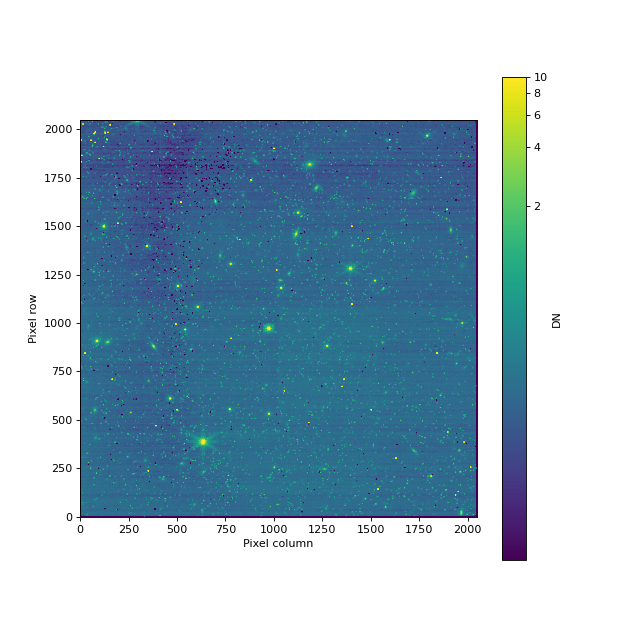

In [17]:
# Look at the rate image
show_image(rate_data, 0.5, 10, units="DN")

## CALWEBB_IMAGE2

Full notebook for CALWEBB_IMAGE2: https://stsci.app.box.com/s/8rulrbsumk3umh1w90k4cruwrsrtwsvo

## Download Data

In [18]:
nircam_info = [('https://stsci.box.com/shared/static/g6316wjr4mv936rlouzdjeq065s7ou6g.fits',
                'jw98765001001_01101_00001_nrcb5_rate.fits'),
               ('https://stsci.box.com/shared/static/z2xunff1d2g3m3fjxc1fixoz8rjfpl7h.fits',
                'jw98765001001_01101_00002_nrcb5_rate.fits'),
               ('https://stsci.box.com/shared/static/4xuvt56kr7gix7dx3tntek6wc9kockef.fits',
                'jw98765001001_01101_00003_nrcb5_rate.fits'),
               ('https://stsci.box.com/shared/static/lzhcnzds2l7mpf92oet1u69uof788u3l.json',
                'level2_lw_asn.json'),
               ('https://stsci.box.com/shared/static/d4pu8ieyjc27wzoe0of3ajb9vjtvc80g.asdf',
                'image2_pipeline_params.asdf')]
nircam_files = download_files(nircam_info, output_dir, force=False)

jw98765001001_01101_00001_nrcb5_rate.fits already exists, skipping download...
jw98765001001_01101_00002_nrcb5_rate.fits already exists, skipping download...
jw98765001001_01101_00003_nrcb5_rate.fits already exists, skipping download...
level2_lw_asn.json already exists, skipping download...
image2_pipeline_params.asdf already exists, skipping download...


In [19]:
# the image2 pipeline is usually run on a set of images defined in an association file
asn_file = os.path.join(output_dir, 'level2_lw_asn.json')

In [20]:
# Create an instance of the pipeline class
image2 = calwebb_image2.Image2Pipeline()

# Set some parameters that pertain to the
# entire pipeline
image2.output_dir = output_dir
image2.save_results = True

# Set some parameters that pertain to some of
# the individual steps
image2.resample.pixfrac = 1.0    # this is the default. Set here as an example

# Call the run() method
image2.run(asn_file)

2021-12-20 12:50:05,321 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.
2021-12-20 12:50:05,323 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2021-12-20 12:50:05,324 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2021-12-20 12:50:05,326 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.
2021-12-20 12:50:05,328 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.
2021-12-20 12:50:05,329 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.
2021-12-20 12:50:05,413 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./level2_lw_asn.json',).
2021-12-20 12:50:05,419 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': No

2021-12-20 12:50:06,052 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs
2021-12-20 12:50:06,123 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done
2021-12-20 12:50:06,199 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00001_nrcb5_rate.fits>,).
2021-12-20 12:50:06,200 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '.', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}
2021-12-20 12:50:06,549 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done
2021-12-20 12:50:06,625 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(2048, 2048) from

2021-12-20 12:50:32,614 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00002_nrcb5_rate.fits>,).
2021-12-20 12:50:32,615 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'photom', 'search_output_file': True, 'input_dir': '.', 'inverse': False, 'source_type': None}
2021-12-20 12:50:32,644 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: ./crds_cache/references/jwst/nircam/jwst_nircam_photom_0095.fits
2021-12-20 12:50:32,645 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: ./crds_cache/references/jwst/nircam/jwst_nircam_area_0026.fits
2021-12-20 12:50:32,731 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM
2021-12-20 12:50:32,732 - stpipe.Image2Pi

2021-12-20 12:50:59,134 - stpipe.Image2Pipeline.photom - INFO - Using instrument: NIRCAM
2021-12-20 12:50:59,135 - stpipe.Image2Pipeline.photom - INFO -  detector: NRCBLONG
2021-12-20 12:50:59,136 - stpipe.Image2Pipeline.photom - INFO -  exp_type: NRC_IMAGE
2021-12-20 12:50:59,136 - stpipe.Image2Pipeline.photom - INFO -  filter: F444W
2021-12-20 12:50:59,137 - stpipe.Image2Pipeline.photom - INFO -  pupil: CLEAR
2021-12-20 12:50:59,199 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.
2021-12-20 12:50:59,201 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 0.389988
2021-12-20 12:50:59,229 - stpipe.Image2Pipeline.photom - INFO - Step photom done
2021-12-20 12:50:59,312 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(2048, 2048) from jw98765001001_01101_00003_nrcb5_rate.fits>,).
2021-12-20 12:50:59,314 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file

[<ImageModel(2048, 2048) from jw98765001001_01101_00001_nrcb5_cal.fits>,
 <ImageModel(2048, 2048) from jw98765001001_01101_00002_nrcb5_cal.fits>,
 <ImageModel(2048, 2048) from jw98765001001_01101_00003_nrcb5_cal.fits>]

### Examine the outputs

In [21]:
# Get a list of input file names from the association file
with open(asn_file) as f_obj:
  asn_data = json.load(f_obj)
input_files = [item['members'][0]['expname'] for item in asn_data['products']]  

2021-12-20 12:51:29,795 - stpipe - WARNING - /user/kgordon/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



In [22]:
# Get a list of the output file names
output_files = sorted(glob(os.path.join(output_dir, '*_cal.fits')))

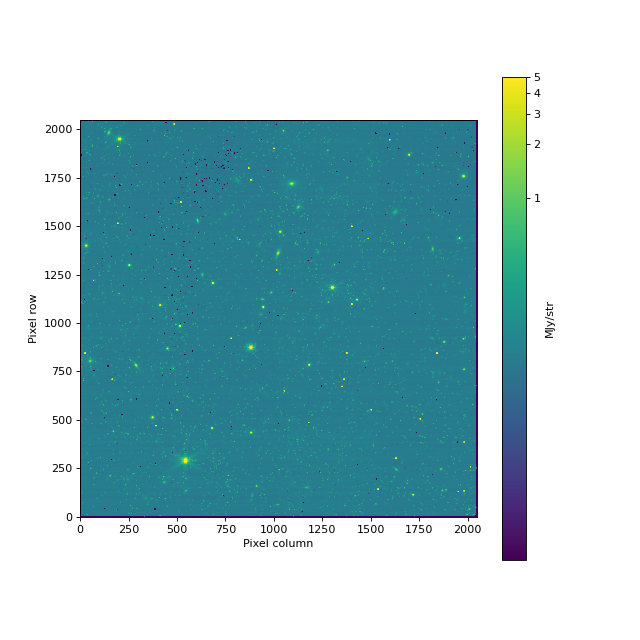

In [23]:
# Show the first calibrated output file
cal_data = fits.open(output_files[0])
show_image(cal_data['SCI'].data, 0.15, 5)
cal_data.close()

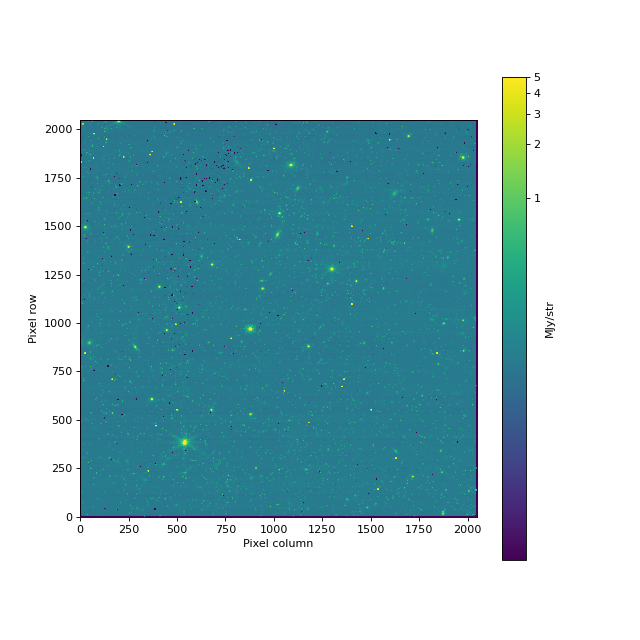

In [24]:
# Show the second calibrated output file
cal_data = fits.open(output_files[1])
show_image(cal_data['SCI'].data, 0.15, 5)
cal_data.close()

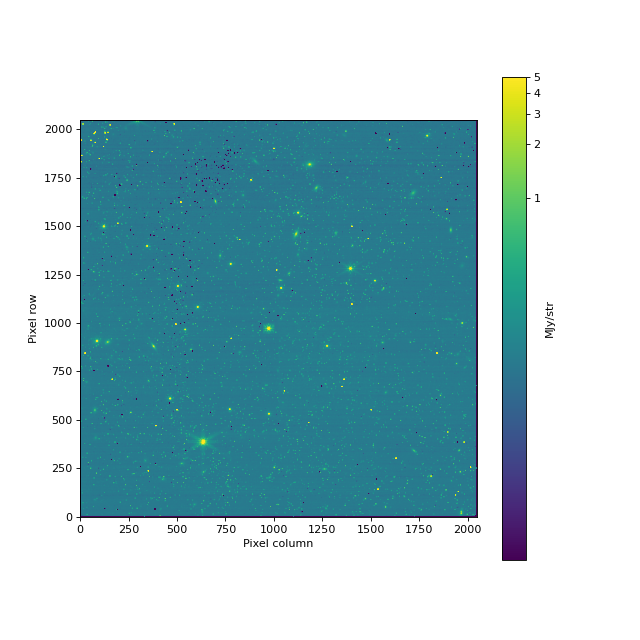

In [25]:
# Show the third calibrated output file
cal_data = fits.open(output_files[2])
show_image(cal_data['SCI'].data, 0.15, 5)
cal_data.close()

## CALWEBB_IMAGE3

Full notebook for CALWEBB_IMAGE3: https://stsci.app.box.com/s/ausbdbmbfi7dhu7yuo4zl56f9ex5qt4b

## Download Data

In [26]:
nircam_info = [('https://stsci.box.com/shared/static/7d00b9isvss7njhcwmd8uiq8c7s4d845.json',
                'level3_lw_asn.json'),
               ('https://stsci.box.com/shared/static/ja0gkd8c0x8p8konhr84wkuhwnpkqf4s.asdf',
                'jwst_nircam_pars-tweakregstep_0006.asdf'),
               ('https://stsci.box.com/shared/static/yahdw55fotwrh7i6hhcxksj97qkf7j4r.asdf',
                'nircam_pars-sourcecatalogstep_f444w_clear.asdf')
              ]
nircam_files = download_files(nircam_info, output_dir, force=False)

level3_lw_asn.json already exists, skipping download...
jwst_nircam_pars-tweakregstep_0006.asdf already exists, skipping download...
nircam_pars-sourcecatalogstep_f444w_clear.asdf already exists, skipping download...


In [27]:
# the image2 pipeline is run on a set of images defined in an association file
asn_file = os.path.join(output_dir, 'level3_lw_asn.json')

In [28]:
# Create an instance of the pipeline class
image3 = calwebb_image3.Image3Pipeline()

# Set some parameters that pertain to the
# entire pipeline
image3.output_dir = output_dir
image3.save_results = True

# Set some parameters that pertain to some of
# the individual steps
image3.tweakreg.snr_threshold = 10.0  # 5.0 is the default
image3.tweakreg.kernel_fwhm = 2.302  # 2.5 is the default
image3.tweakreg.brightest = 20  # 100 is the default
image3.source_catalog.kernel_fwhm = 2.302  # pixels
image3.source_catalog.snr_threshold = 10.

# Call the run() method
image3.run(asn_file)

2021-12-20 12:51:30,861 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.
2021-12-20 12:51:30,863 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2021-12-20 12:51:30,865 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.
2021-12-20 12:51:30,867 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.
2021-12-20 12:51:30,869 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2021-12-20 12:51:30,870 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.
2021-12-20 12:51:30,872 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.
2021-12-20 12:51:30,965 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('./level3_lw_asn.json',).
2021-12-20 12:51:30,972 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './', '

2021-12-20 12:51:42,656 - stpipe.Image3Pipeline.tweakreg - INFO - Found initial X and Y shifts of 0, 0 with significance of 19 and 21 matches.
2021-12-20 12:51:42,657 - stpipe.Image3Pipeline.tweakreg - INFO - Found 19 matches for 'GROUP ID: jw98765001001_01101_00002_nrcb5_cal'...
2021-12-20 12:51:42,658 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'general' fit
2021-12-20 12:51:42,660 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'general' fit for GROUP ID: jw98765001001_01101_00002_nrcb5_cal:
2021-12-20 12:51:42,661 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: 0.00237299  YSH: 0.000284487    PROPER ROT: -0.00203833    
2021-12-20 12:51:42,662 - stpipe.Image3Pipeline.tweakreg - INFO - <ROT>: -0.00203833  SKEW: -0.00628721    ROT_X: 0.00110528  ROT_Y: -0.00518194
2021-12-20 12:51:42,662 - stpipe.Image3Pipeline.tweakreg - INFO - <SCALE>: 0.99998  SCALE_X: 1.00001  SCALE_Y: 0.999948
2021-12-20 12:51:42,663 - stpipe.Image3Pipeline.tweakreg - INFO - 
2021-12-20 12:51:42,663 -

2021-12-20 12:51:55,857 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (2048, 2048) --> (2166, 2170)
2021-12-20 12:52:02,260 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (2048, 2048) --> (2166, 2170)
2021-12-20 12:52:06,121 - stpipe.Image3Pipeline.outlier_detection - INFO - Generating median from 3 images
2021-12-20 12:52:07,052 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting median...
2021-12-20 12:52:09,948 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2166, 2170)
2021-12-20 12:52:14,131 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2166, 2170)
2021-12-20 12:52:18,230 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (2048, 2048) <-- (2166, 2170)
2021-12-20 12:52:23,700 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./jw98765001001_01101_00001_nrcb5_a3001_crf.fits
2021-12-20 12:52:27,232 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model i

### Examine the outputs

In [29]:
# Open the association file and load into a json object
with open(asn_file) as f_obj:
  asn_data = json.load(f_obj)
input_files = [item['expname'] for item in asn_data['products'][0]['members']]  

mosaic_file = os.path.join(output_dir, 'l3_lw_results_i2d.fits')
source_cat_file = os.path.join(output_dir, 'l3_lw_results_cat.ecsv')
segmentation_map_file = os.path.join(output_dir, 'l3_lw_results_segm.fits')
cr_flagged_files = [item.replace('cal.fits', 'crf.fits') for item in input_files]

2021-12-20 12:53:51,095 - stpipe - WARNING - /user/kgordon/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Read in the final mosaic image and display

Note that there are low level residual horizontal instrument artifacts present in the final mosaic.

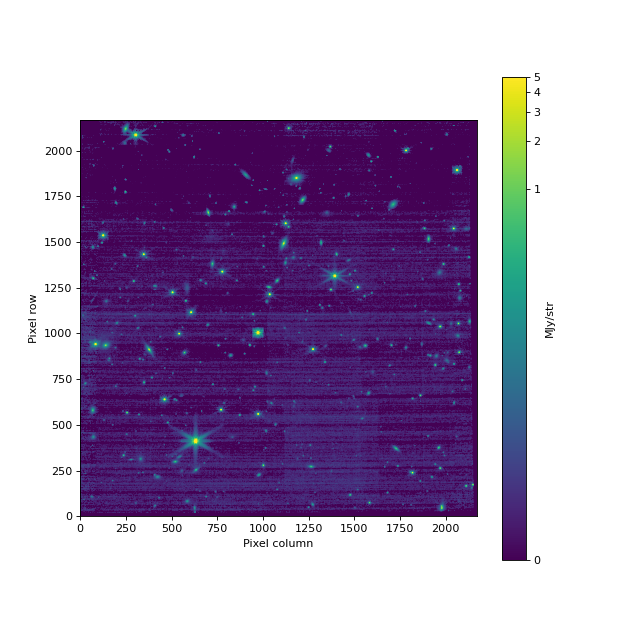

In [30]:
mosaic = datamodels.open(mosaic_file)
show_image(mosaic.data, vmin=-0, vmax=5)

Let's look at the segmentation map that was created by the `source_catalog` step. This shows which pixels are associated with the identified sources.

2021-12-20 12:53:51,683 - stpipe - WARNING - /user/kgordon/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



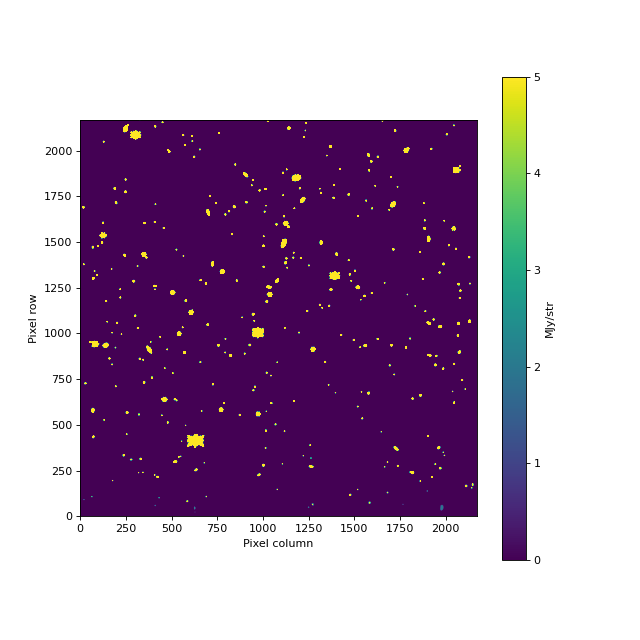

In [31]:
seg_map = fits.getdata(segmentation_map_file)
show_image(seg_map, vmin=0, vmax=5, scale='linear')

And now examine the actual source catalog. For each source, the catalog lists the location, along with flux and AB/Vega magnitude values in three different apertures, as well as calculated values for an infinite aperture. Within the documentation, you can see the [full list of column definitions](https://jwst-pipeline.readthedocs.io/en/stable/jwst/source_catalog/main.html#source-catalog-table).

In [32]:
source_cat = ascii.read(source_cat_file)
source_cat

label,xcentroid,ycentroid,sky_centroid,aper_bkg_flux,aper_bkg_flux_err,aper30_flux,aper30_flux_err,aper50_flux,aper50_flux_err,aper70_flux,aper70_flux_err,aper_total_flux,aper_total_flux_err,aper30_abmag,aper30_abmag_err,aper50_abmag,aper50_abmag_err,aper70_abmag,aper70_abmag_err,aper_total_abmag,aper_total_abmag_err,aper30_vegamag,aper30_vegamag_err,aper50_vegamag,aper50_vegamag_err,aper70_vegamag,aper70_vegamag_err,aper_total_vegamag,aper_total_vegamag_err,CI_50_30,CI_70_50,CI_70_30,is_extended,sharpness,roundness,nn_label,nn_dist,isophotal_flux,isophotal_flux_err,isophotal_abmag,isophotal_abmag_err,isophotal_vegamag,isophotal_vegamag_err,isophotal_area,semimajor_sigma,semiminor_sigma,ellipticity,orientation,sky_orientation,sky_bbox_ll,sky_bbox_ul,sky_bbox_lr,sky_bbox_ur
,,,"deg,deg",Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,,pix,Jy,Jy,,,,,pix2,pix,pix,,deg,deg,"deg,deg","deg,deg","deg,deg","deg,deg"
int64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float32,int64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,object,object,object,object
1,628.0367,20.9037,"12.005762282905344,11.98237535795924",0.000000e+00,1.231027e-10,1.599428e-07,3.709140e-02,2.949162e-07,5.407239e-02,4.909970e-07,1.001702e-01,7.236804e-07,1.476409e-01,25.890088,13.413276,25.225753,13.158198,24.672303,13.274155,24.251133,13.274155,22.648278,13.413276,21.983943,13.158198,21.430493,13.274155,21.009323,13.274155,1.8439,1.6649,3.0698,False,0.559759,0.157341,3,22.298404,4.563310e-07,8.283063e-02,24.751801,13.147284,21.509991,13.147284,21.0,1.129559,1.098430,0.027558,86.530101,176.532870,"12.005807679798028,11.982333271651415","12.005807688191592,11.982438317670697","12.005700294016584,11.982333279836826","12.005700302368288,11.98243832585616"
2,1977.0889,46.1400,"11.981617435987035,11.982817995504341",3.290850e-08,3.885622e-09,4.080424e-07,5.725178e-02,9.655877e-07,8.776130e-02,5.835249e-06,2.179737e-01,8.600573e-06,3.212715e-01,24.873237,12.867717,23.938021,12.396290,21.984851,11.430891,21.563681,11.430891,21.631427,12.867717,20.696211,12.396290,18.743041,11.430891,18.321871,11.430891,2.3664,6.0432,14.3006,True,0.563867,0.407857,16,120.058847,2.274130e-05,4.330060e-01,20.507961,10.699253,17.266151,10.699253,386.0,5.657726,2.497967,0.558486,88.372489,178.375259,"11.981771160465728,11.982526668831294","11.98177115543529,11.983069406587347","11.981431105264846,11.982526665639279","11.981431099549702,11.983069403394452"
3,626.3354,43.1371,"12.005792761731694,11.982764610902487",3.459686e-09,5.383820e-10,6.583049e-08,2.869345e-02,1.319742e-07,4.155062e-02,4.517474e-07,9.019887e-02,6.658305e-07,1.329441e-01,26.853932,14.098392,26.098777,13.745224,24.762761,13.250769,24.341591,13.250769,23.612122,14.098392,22.856967,13.745224,21.520951,13.250769,21.099781,13.250769,2.0048,3.4230,6.8623,True,0.557633,0.358410,1,22.298404,9.754908e-07,1.241765e-01,23.926941,12.762050,20.685131,12.762050,71.0,3.383826,1.379110,0.592441,-86.588798,3.413972,"12.005843498879804,11.98263089930212","12.005843521299878,11.982911022021435","12.005718215329775,11.982630908863843","12.005718237619663,11.982911031583233"
4,1249.0278,47.1595,"11.994648028320682,11.982835664274223",5.247196e-10,1.443432e-10,2.123149e-07,3.927804e-02,3.787766e-07,5.433622e-02,5.864700e-07,9.232596e-02,8.643981e-07,1.360792e-01,25.582549,13.167929,24.954042,12.891773,24.479385,12.992702,24.058215,12.992702,22.340739,13.167929,21.712232,12.891773,21.237575,12.992702,20.816405,12.992702,1.7840,1.5483,2.7623,False,0.632529,0.071964,6,27.597046,5.886711e-07,8.181189e-02,24.475319,12.857367,21.233509,12.857367,24.0,1.191757,1.122187,0.058376,89.961545,179.964315,"11.994693268831606,11.982789101453847","11.994693273570846,11.982911655145

Finally, let's overlay the source catalog on top of the mosaic image. In order to cut down on the number of spurious detections, we only show sources above a minimum flux limit. Another way to cut down on the number of spurious detections would be to change some of the `source_catalog` parameter values when calling the pipeline above.

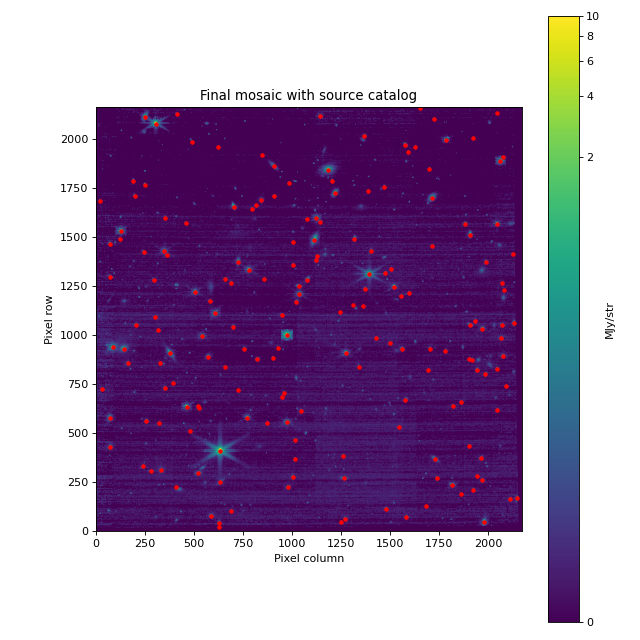

In [33]:
overlay_catalog(mosaic.data, source_cat, flux_limit=5e-7, vmin=0, vmax=10,
                title='Final mosaic with source catalog')